# Clase 10: Selección de Características y Ajuste de Hiperparámetros

**MDS7202: Laboratorio de Programación Científica para Ciencia de Datos**

## Objetivos de esta clase

- Comprender la importancia de seleccionar características.
- Seleccionar Características relevantes.
- Integrar estas técnicas con `Pipeline`.
- Buscar la mejor configuración de hiperparámetros con `GridSearch`.

## Importamos Librerías

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("../../recursos/2023-01/22_hiper/descriptores_musica.csv")
df = df.astype({"time_signature": str, "key": str, "mode": str})

---

## Problema de Hoy: 🎸🤘 Caracterización Musical 🎼🎵 

<center>
<img src='https://media.tenor.com/2HL1y7peaysAAAAM/2pac-hit-em-up.gif' width=250 />

Los atributos son: 

- `key`: escala de la canción. 0 = C, 1 = C♯/D♭, 2 = D...  [Mas información](https://en.wikipedia.org/wiki/Pitch_class).
- `modo`: 1 si la escala es mayor, 0 si es menor.
- `time_signature`: cuántos pulsos hay en cada compás. (4, 3,...).
- `loudness`: Volumen de la canción (rango -60, 0).


- `acousticness`: Probabilidad de que la canción sea solo acústica. Valores cercanos a 1 indican que la canción es probablemente acústica.
- `danceability`: Describe que tan bailable es la canción. Valores cercanos a 1 indican que la canción es muy bailable.
- `energy`: Mide que tan energética es una canción. Mide cosas como la rapidez, el volumen y el ruido. Valores cercanos a 1 indican que la canción es muy enégrica.
- `instrumentalness`: Probabilidad que la canción contenga voces. 1 es muy probable que contenga voz.
- `liveness`: Probabilidad de que la canción fuese grabada en vivo. 1 es muy probable que la canción haya sido grabada en vivo.
- `speechiness`: Probabilidad de que la canción contenga palabras habladas (ejemplo: podcast : 1). 
- `valence`: Sentimiento de la canción (rango 0, 1). 1 -> felicidad, alegria, euforia. 0 -> Tristeza, enojo, depresión.
- `tempo` : Pulsos por minuto de la canción (BPM). 


La variable a predecir es: 

- `genre`: Género de la canción.

### Análisis Exploratorio de Datos

In [2]:
import pandas as pd
import plotly.express as px

df.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,name,artist,genre
0,0.617,0.771,10,-5.586,0,0.1120,0.0384,0.000003,0.1620,0.553,180.002,3nCFiwtuVqVJmnSasApvr3,267747,4,Salgo Pa' la Calle,Daddy Yankee,Reggaeton
1,0.788,0.674,2,-8.392,1,0.0537,0.2810,0.033000,0.0892,0.864,94.997,5I0u5YHYvA6fQZstVCFwqC,214747,4,Dile A Tu Amiga,Ñejo,Reggaeton
2,0.745,0.744,5,-8.230,1,0.0837,0.0266,0.000018,0.0959,0.849,96.026,1FTTvjvgX2Qd9ZJqo36m1C,244663,4,Nada Va Pasar,Yaga Y Mackie,Reggaeton
3,0.782,0.767,9,-7.981,0,0.0871,0.2660,0.000036,0.0947,0.622,88.005,6DxS2ZRl8G3EagHkovYXA2,304091,4,Zun Da Da,Zion,Reggaeton
4,0.702,0.864,1,-5.496,1,0.0818,0.1080,0.000000,0.1870,0.788,94.994,4mM90OUhSN79RRKT0qv4dY,215118,4,Fuera del Planeta,Randy,Reggaeton


In [3]:
df.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,8.140000e+02
mean,0.600392,0.589244,-10.017713,0.090809,0.324999,0.159151,0.181294,0.532020,113.486484,2.838903e+05
std,0.196368,0.268840,6.429775,0.095219,0.342813,0.304559,0.151797,0.268382,26.527836,1.284673e+05
min,0.062300,0.002100,-42.238000,0.023200,0.000017,0.000000,0.031100,0.030800,59.406000,8.426700e+04
25%,0.479250,0.417500,-11.555500,0.036500,0.033450,0.000000,0.090675,0.324000,94.013500,2.112300e+05
50%,0.641500,0.663500,-7.997500,0.047550,0.180000,0.000405,0.122000,0.569000,110.033500,2.512800e+05
75%,0.753000,0.799000,-5.854750,0.098000,0.575250,0.095600,0.226750,0.754000,126.928250,3.087402e+05
max,0.976000,0.989000,-1.446000,0.817000,0.996000,0.958000,0.987000,0.981000,213.990000,1.252322e+06


In [7]:
def get_ejemplo(idx):
    """
    Obtiene un ejemplo y lo formatea como columna.
    """
    ejemplo = (
        df.loc[
            idx,
            [
                "danceability",
                "energy",
                "speechiness",
                "acousticness",
                "instrumentalness",
                "valence",
                "name",
                "artist",
                "genre",
            ],
        ]
        .to_frame()
        .reset_index()
    )
    ejemplo.columns = ["Descriptor", "Valor"]
    return ejemplo

In [5]:
# pueden cambiar el índice de alguno de estos ejemplos para
# mostrar otra canción en la visualización
ejemplo1 = get_ejemplo(102)
ejemplo2 = get_ejemplo(385)
ejemplo3 = get_ejemplo(15)
ejemplo4 = get_ejemplo(484)

ejemplos = [ejemplo1, ejemplo2, ejemplo3, ejemplo4]

#### Spider/Radar Chart

In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2,
    cols=2,
    specs=[
        [{"type": "polar"}, {"type": "polar"}],
        [{"type": "polar"}, {"type": "polar"}],
    ],
    subplot_titles=[
        ejemplo1.loc[6, "Valor"],
        ejemplo3.loc[6, "Valor"],
        ejemplo2.loc[6, "Valor"],
        ejemplo4.loc[6, "Valor"],
    ],
)

for i, ejemplo in enumerate(ejemplos):
    fig.add_trace(
        go.Scatterpolar(
            r=ejemplo.loc[0:5, "Valor"],
            theta=ejemplo.loc[0:5, "Descriptor"],
            fill="toself",
            name=f"{ejemplo.loc[6, 'Valor']} - {ejemplo.loc[7, 'Valor']} ({ejemplo.loc[8, 'Valor']})",
        ),
        col=i // 2 + 1,
        row=i % 2 + 1,
    )

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
    showlegend=False,
    title="ScatterPolar/Radar/Spider Chart/ Descripción de Ejemplos",
    height=700,
)

fig.show()

#### Histogramas

In [7]:
dt_to_hists = df.loc[
    :,
    [
        "danceability",
        "energy",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "valence",
        "liveness",
        "genre",
    ],
].melt(id_vars=["genre"], var_name="variable", value_name="valor")

px.histogram(
    dt_to_hists, x="valor", color="variable", facet_col="variable", facet_col_wrap=4
).update_layout(showlegend=False)

In [8]:
from sklearn.preprocessing import MinMaxScaler, Normalizer
from umap import UMAP

projection_pipe = Pipeline(
    [
        (
            "Column Transformer",
            ColumnTransformer(
                [("MinMax", MinMaxScaler(), ["duration_ms", "loudness"])],
                remainder="passthrough",
            ),
        ),
        ("Normalize", Normalizer()),
        ("UMAP", UMAP(random_state=88, n_neighbors=20, min_dist=0.15)),
    ]
)


projections = projection_pipe.fit_transform(
    df.loc[
        :,
        [
            "danceability",
            "energy",
            "speechiness",
            "acousticness",
            "instrumentalness",
            "valence",
            "liveness",
            "duration_ms",
            "loudness",
        ],
    ]
)
df_proj = pd.DataFrame(projections, columns=["x", "y"])


df_fig = df.copy()
df_fig = pd.concat([df_fig, df_proj], axis=1)
df_fig["hover_name"] = df_fig["artist"] + " - " + df_fig["name"]

fig = px.scatter(
    df_fig,
    x="x",
    y="y",
    color="genre",
    hover_name="hover_name",
    hover_data=[
        "danceability",
        "energy",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "valence",
    ],
)
fig.show()

## Motivación 

### Detalle Interesante 1: Correlación entre las variables.


$$corr (X, Y) = \frac{1}{(s_{x} s_{y})} \sum_{i=1}^{m} (x_i - \overline{x})(y_i - \overline{y}) $$


Los valores varian entre -1 y 1

- Positivo: Relación directa: Crece una, crece la otra. Mientras mayor, mas similares son las variables.
- Negativo: Relación inversa: Crece una, decrece la otra.


In [9]:
correlations_df = df[
    [
        "danceability",
        "energy",
        "loudness",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "liveness",
        "valence",
        "tempo",
    ]
]
correlations = correlations_df.corr()


px.imshow(
    correlations,
    labels=dict(x="", y="", color="Correlation"),
    x=correlations_df.columns,
    y=correlations_df.columns,
    zmin=-1,
    zmax=1,
    color_continuous_scale="Inferno",
)

### Detalle Interesante 2: Correlación entre las variables de Entrada y la variable por Predecir 

In [10]:
labels = df.loc[:, ["genre"]]
labels

,genre
0,Reggaeton
1,Reggaeton
2,Reggaeton
3,Reggaeton
4,Reggaeton
...,...
809,Pop
810,Pop
811,Pop
812,Pop


In [11]:
encoder = OneHotEncoder(sparse_output=False)
encoded_labels = encoder.fit_transform(labels)

encoded_labels_df = pd.DataFrame(encoded_labels, columns=encoder.get_feature_names_out())
encoded_labels_df

,genre_Clasica,genre_Disco,genre_Electronica,genre_Hiphop,genre_Jazz,genre_Pop,genre_Reggaeton,genre_Rock,genre_Rock latino
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
809,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
810,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
811,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
812,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
# juntamos correlations_df con encoded_labels_df

correlations_labels_df = pd.concat([correlations_df, encoded_labels_df], axis=1)

correlations_labels = correlations_labels_df.corr("pearson").iloc[9:, 0:9]

px.imshow(
    correlations_labels,
    labels=dict(x="", y="", color="Correlation"),
    x=correlations_labels.columns,
    y=correlations_labels.index,
    zmin=-1,
    zmax=1,
    color_continuous_scale="PRgn",
)

### Detalle Interesante 3: ¿Usamos Artista?

In [13]:
df["artist"].value_counts()

artist
Daddy Yankee               6
Johann Sebastian Bach      6
John Coltrane              6
Miles Davis                5
The Rolling Stones         5
                          ..
Tantra                     1
Machine                    1
Grandmaster Flash          1
Evelyn "Champagne" King    1
Rachel Platten             1
Name: count, Length: 506, dtype: int64

In [14]:
px.histogram(
    df,
    "artist",
)

In [15]:
artista_ohe = OneHotEncoder(sparse_output=False)
artista_encoded = artista_ohe.fit_transform(df[["artist"]])
artista_cols = artista_ohe.get_feature_names_out()


artista_df = pd.DataFrame(artista_encoded, columns=artista_cols)
artista_df

,artist_2Pac,artist_A Taste Of Honey,artist_A Tribe Called Quest,artist_AC/DC,artist_AWOLNATION,artist_Aaron Copland,artist_Adele,artist_Aerosmith,artist_Afu-Ra,artist_Alec Benjamin,...,artist_ZZ Top,artist_Zedd,artist_Zion,artist_Zion & Lennox,artist_Zoé,artist_Zurdok,artist_deadmau5,artist_lovelytheband,artist_Ñejo,artist_Ñejo & Dalmata
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
810,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
artista_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Columns: 506 entries, artist_2Pac to artist_Ñejo & Dalmata
dtypes: float64(506)
memory usage: 3.1 MB


**Esta transformación produce 506 dimensiones. Una locura...**

> **Pregunta:** ¿La cantidad de dimensiones influirá en la calidad de clasificación que logremos?

Imagínense ahora las correlaciones de cada una de estas viariables con respecto a la variable de salida.

### Maldición de la Dimensionalidad

La maldición de la dimensionalidad es el problema que consiste en que a medida que aumentan las dimensiones, los datos tienden a hacerse cada vez más *sparse*/escasos sobre las dimensiones en las cuales están representados. Una simple analogía para entender esto es que:

> *A medida que aumenta la cantidad de features, aumenta el volumen en donde se encuentran los datos, haciendo que estos se separen bastante entre ellos. *



<div align='center'>
    <img src='https://github.com/MDS7202/MDS7202/blob/main/recursos/2023-01/22_hiper/curse.png?raw=true' width=600/>
</div>

<div align='center'>
    Fuente: <a href='https://www.researchgate.net/figure/The-effect-of-the-curse-of-dimensionality-when-projected-in-1-one-dimension-2-two_fig3_342638066'> A comprehensive survey of anomaly detection techniques for high dimensional big data en Research Gate.</a>
</div>


Esto implica que, para poder seguir distinguiendo correctamente los datos, se debe aumentar masivamente su cantidad a medida que se aumentan las dimensiones.

**¿En qué nos afecta esto?**

Induce comunmente a una reducción del rendimiento de los clasificadores/regresores.


Más en Wikipedia: [Curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

## Mejorando la Clasificación

Entonces, hasta acá tenemos 3 problemas: 

1. Hay características que "aportan" más o menos la misma información.
2. Hay características que podrían no aportar información para poder clasificar correctamente.
3. Tenemos una gran cantidad de dimensiones, lo cual podría entorpecer la clasificación.


Por ende, sería ideal eliminar un par de dimensiones con el fin de mejorar la clasificación. 


Para comparar las mejoras, utilizaremos un **Baseline**, el cual no es más que es un modelo inicial al cual, a medida que vayamos generando mejores modelos, nos iremos comparando (para ver si mejoramos y cuanto). Durante toda esta clase, nuestro **baseline** (modelo que compararemos) será **Tree** entrenado con todas las features.


In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

preprocessing = ColumnTransformer(
    [
        (
            "Scale",
            MinMaxScaler(),
            [
                "duration_ms",
                "tempo",
                "loudness",
                "time_signature",
            ],
        ),
        (
            "One Hot Encoding",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
            [
                "key",
                "mode",
                "artist",
                "time_signature",
            ],
        ),
    ],
    remainder="passthrough",
)

# Creamos nuestro baseline pipeline
baseline_pipe = Pipeline(
    steps=[
        ("Preprocessing", preprocessing),
        ("Tree", DecisionTreeClassifier(random_state=42)),
    ]
)

Aplicamos **holdout** al dataset

In [18]:
from sklearn.model_selection import train_test_split

labels = df.loc[:, "genre"]
features = df.drop(columns=["genre", "id", "name"])

X_train, X_test, y_train, y_test = train_test_split(
    features,
    labels,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=labels,
)

Ahora, definimos el ciclo de Entrenamiento y Evaluación.
La métrica con la cuál evaluaremos el desempeño del clasificador será `f1_score`.

Para esto, definiremos la función `train_and_evaluate` que dado un pipeline y conjuntos de entrenamiento y prueba, entrena un clasificador y retorna su evaluación:



In [19]:
from sklearn.metrics import f1_score


def train_and_evaluate(
    pipe, print_=True, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
):

    # notar que los datasets son parámetros por defecto.

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    if print_:
        print("Matriz de confusión: \n")
        print(confusion_matrix(y_test, y_pred, labels=pipe.classes_))
        print("\nReporte de Clasificación: \n")
        print(
            classification_report(y_test, y_pred, target_names=pipe.classes_),
        )
    return f1_score(y_test, y_pred, average="macro")


train_and_evaluate(baseline_pipe)

Matriz de confusión: 

[[17  0  0  0  2  0  0  0  1]
 [ 0 10  0  1  0  1  1  1  3]
 [ 0  4  4  3  0  0  1  0  0]
 [ 0  0  0 17  0  1  1  0  1]
 [ 4  0  0  0  6  1  0  2  1]
 [ 0  1  2  1  1 11  0  3  1]
 [ 0  0  0  6  0  2 11  0  1]
 [ 0  4  1  0  0  1  2 12  0]
 [ 0  7  2  0  1  2  1  4  3]]

Reporte de Clasificación: 

              precision    recall  f1-score   support

     Clasica       0.81      0.85      0.83        20
       Disco       0.38      0.59      0.47        17
 Electronica       0.44      0.33      0.38        12
      Hiphop       0.61      0.85      0.71        20
        Jazz       0.60      0.43      0.50        14
         Pop       0.58      0.55      0.56        20
   Reggaeton       0.65      0.55      0.59        20
        Rock       0.55      0.60      0.57        20
 Rock latino       0.27      0.15      0.19        20

    accuracy                           0.56       163
   macro avg       0.54      0.54      0.53       163
weighted avg       0.55    

0.5341493781401013

> **Pregunta:❓** ¿Cómo sé que mi modelo es mejor que uno que clasifica al azar?


### Modelos Dummy

<center>
<img src='https://i0.wp.com/media1.giphy.com/media/YWzqX7pyn1oUE/giphy.gif' width=250 />

El [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier) es un clasificador que ignora todas las features de entrada y genera salidas aleatorias como respuesta a las predicciones.

Permite saber si los modelos que estamos implementando son mejores que clasificar al azar. Por lo general, es una de las primeros chequeos que hacemos ya que permite anticipadamente saber si estamos generando modelos que aprenden o no.

Para la regresión, existe [DummyRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html#sklearn.dummy.DummyRegressor).

In [20]:
from sklearn.dummy import DummyClassifier

dummy_pipe = Pipeline(
    steps=[
        ("Preprocessing", preprocessing),
        ("Tree", DummyClassifier(strategy="stratified")),
    ]
)

train_and_evaluate(dummy_pipe)

Matriz de confusión: 

[[1 2 2 1 3 2 2 3 4]
 [1 2 3 0 2 3 3 1 2]
 [0 2 2 1 1 1 3 0 2]
 [2 0 3 5 1 2 0 5 2]
 [2 2 0 4 1 1 3 1 0]
 [1 2 2 3 2 2 2 1 5]
 [4 3 4 1 1 2 2 2 1]
 [2 3 0 1 0 2 3 4 5]
 [4 2 1 2 1 1 3 3 3]]

Reporte de Clasificación: 

              precision    recall  f1-score   support

     Clasica       0.06      0.05      0.05        20
       Disco       0.11      0.12      0.11        17
 Electronica       0.12      0.17      0.14        12
      Hiphop       0.28      0.25      0.26        20
        Jazz       0.08      0.07      0.08        14
         Pop       0.12      0.10      0.11        20
   Reggaeton       0.10      0.10      0.10        20
        Rock       0.20      0.20      0.20        20
 Rock latino       0.12      0.15      0.14        20

    accuracy                           0.13       163
   macro avg       0.13      0.13      0.13       163
weighted avg       0.14      0.13      0.13       163



0.13237638861854994

## Selección de Features

<center>
<img src='https://media.tenor.com/YhfKx7iugisAAAAM/streets-of-rage-player-select.gif' width=300 />

Entonces, recordando los 3 problemas que habíamos mencionado previamente: 

1. Hay características que "aportan" más o menos la misma información.
2. Hay características que podrían no aportar información para poder clasificar correctamente.
3. Tenemos una gran cantidad de dimensiones, lo cual podría entorpecer la clasificación.

Los **métodos de filtrado** son algoritmos de selección que eligen o eliminan características basándose únicamente en sus propiedades estadísticas, sin involucrar algoritmos de machine learning complejos. La eliminación de características constantes es un claro ejemplo de estos métodos de filtrado, ya que se fundamenta en la ausencia de variabilidad de dichas características.

Al incorporar estos pasos tempranos en el flujo de trabajo de ciencia de datos, no solo se mejora la eficiencia del proceso, sino que también se sientan las bases para construir modelos de machine learning más robustos y precisos.

### Drop Features constantes o casi constantes

<center>
<img src='https://media.tenor.com/4ZigJATvs64AAAAM/whoa-how-very-very-relevant-eric-cartman.gif' width=250 />

#### ¿Por Qué Eliminar Features Constantes?

Las features con poca o ninguna variabilidad aportan escasa o nula información útil al modelo. Su eliminación desde el inicio del proyecto ayuda a simplificar el conjunto de datos.

Para eliminar variables constantes se utiliza `DropConstantFeatures`. La principal característica de esta función es que permite eliminar características especificando una tolerancia, es decir, el número mínimo de observaciones distintas que una característica debe tener. En el ejemplo a continuación, se establece que las características pueden tener hasta un 65% de un mismo valor repetido; de lo contrario, deben ser eliminadas.

Es importante notar que el nivel de tolerancia dependerá del problema a resolver, ya que en algunos casos, una baja cardinalidad en una variable podría ser un reflejo de un efecto outlier que se desea capturar.

In [21]:
from feature_engine.selection import DropConstantFeatures

transformer = DropConstantFeatures(tol=0.65)

Luego, para eliminar las features y siguiendo la misma lógica de sk-learn aplicamos el método `fit_transform`:

In [22]:
# notar que en un comienzo tenemos 14 columnas
X_train.shape

(651, 14)

In [23]:
transformer.fit_transform(X_train).shape

(651, 13)

Para identificar la feature eliminada puede revisar el atributo `features_to_drop_` del transformador, obteniendo:

In [24]:
transformer.features_to_drop_

['time_signature']

In [25]:
X_train['time_signature'].value_counts()

time_signature
4    604
3     37
1      6
5      4
Name: count, dtype: int64

Por otro lado, si deseamos integrar esto dentro de un pipeline de Scikit-learn, ¡no hay problema! La librería es completamente compatible con este enfoque.

In [26]:
# Creamos nuestro baseline pipeline
selection_pipeline = Pipeline(
    steps=[
        ("Preprocessing", preprocessing),
        # Conservamos el 65% mejor según la métrica seleccionada
        ("dropconstant", DropConstantFeatures(tol=0.65)),
        ("Tree", DecisionTreeClassifier(random_state=42)),
    ]
)

train_and_evaluate(selection_pipeline)

Matriz de confusión: 

[[17  0  0  0  3  0  0  0  0]
 [ 0  7  1  2  0  1  2  1  3]
 [ 0  1  5  2  1  0  0  2  1]
 [ 0  0  1 16  0  1  1  1  0]
 [ 2  2  0  0  7  1  0  2  0]
 [ 0  0  2  0  0 13  0  1  4]
 [ 0  0  0  5  0  2 11  1  1]
 [ 0  2  1  1  0  2  1  8  5]
 [ 0  5  2  1  1  3  0  5  3]]

Reporte de Clasificación: 

              precision    recall  f1-score   support

     Clasica       0.89      0.85      0.87        20
       Disco       0.41      0.41      0.41        17
 Electronica       0.42      0.42      0.42        12
      Hiphop       0.59      0.80      0.68        20
        Jazz       0.58      0.50      0.54        14
         Pop       0.57      0.65      0.60        20
   Reggaeton       0.73      0.55      0.63        20
        Rock       0.38      0.40      0.39        20
 Rock latino       0.18      0.15      0.16        20

    accuracy                           0.53       163
   macro avg       0.53      0.53      0.52       163
weighted avg       0.53    

0.5227963891776145

### Selección Inteligente de Features por Correlación

Al trabajar con conjuntos de datos que contienen numerosas features, es común que más de dos features muestren correlaciones entre sí. Esta correlación puede manifestarse entre tres, cuatro o incluso más características dentro del conjunto de datos. En consecuencia, determinar qué características conservar y cuáles eliminar se convierte en una consideración crucial y realizar una mala selección podría significar perdida en puntos de predictibilidad.

Decidir qué feature retener de un grupo correlacionado implica varias estrategias, como:

1. **Rendimiento del Modelo**: Algunas features generan modelos con un rendimiento superior en comparación con otras.
2. **Variabilidad y Cardinalidad**: Las features con mayor variabilidad o cardinalidad suelen proporcionar más información sobre la variable objetivo.
3. **Datos Faltantes**: Las features con menos datos faltantes suelen ser más confiables e informativas.

Podemos aplicar estas estrategias de selección de manera automática utilizando la función **SmartCorrelatedSelection**. La función retiene la variable dentro de un grupo de variables correlacionadas que cumpla con los siguientes criterios:

- **Mayor Varianza**: La feature con la mayor diversidad de valores.
- **Mayor Cardinalidad**: La feature con más valores únicos.
- **Menor Cantidad de Datos Faltantes**: La feature más completa y confiable.
- **Mejor Rendimiento del Modelo**: La feature que produce el modelo de mejor rendimiento.

Las features restantes dentro de cada grupo correlacionado serán eliminadas. Más detalle de las funcionalidades que ofrece la función aquí: [link](https://feature-engine.trainindata.com/en/latest/api_doc/selection/SmartCorrelatedSelection.html#feature_engine.selection.SmartCorrelatedSelection)

Para utilizar esta función, se debe importar `SmartCorrelatedSelection` del módulo de selección de características. Luego, se deben proporcionar los parámetros deseados para la selección:

In [ ]:
from feature_engine.selection import SmartCorrelatedSelection

tr = SmartCorrelatedSelection(
    method="pearson",
    threshold=0.8,
    missing_values="raise",
    selection_method="variance"
)

Luego, para ver que variables estan relacionadas aplicamos:

In [28]:
tr.fit_transform(X_train)

,danceability,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist
184,0.630,1,-8.128,0,0.0309,0.4630,0.040800,0.1730,0.5090,118.650,270773,4,The Rolling Stones
672,0.721,6,-5.685,1,0.2780,0.0495,0.000000,0.3270,0.8350,83.028,240093,4,Camp Lo
712,0.650,1,-4.099,0,0.3740,0.0252,0.000000,0.1760,0.6590,89.788,206493,4,Black Star
698,0.770,10,-11.169,0,0.2460,0.1100,0.000000,0.0793,0.7880,98.820,253413,4,Pete Rock & C.L. Smooth
0,0.617,10,-5.586,0,0.1120,0.0384,0.000003,0.1620,0.5530,180.002,267747,4,Daddy Yankee
...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,0.518,5,-4.616,1,0.0302,0.0259,0.000000,0.1090,0.2090,120.019,340707,4,Harry Styles
345,0.684,2,-11.001,1,0.0495,0.2010,0.000000,0.0727,0.7630,123.377,383827,4,Harold Melvin & The Blue Notes
584,0.854,10,-2.516,0,0.0347,0.0083,0.513000,0.1350,0.6390,126.015,159048,4,Valentino Khan
375,0.720,0,-7.634,1,0.0268,0.0644,0.009480,0.3610,0.8540,120.747,260747,4,Kelly Marie


In [29]:
tr.correlated_feature_sets_

[{'energy', 'loudness'}]

Para revisar que feature será retenida y cual será eliminada se realiza lo siguiente:

In [30]:
tr.correlated_feature_dict_

{'loudness': {'energy'}}

¿Por qué fue seleccionada `loudness` y no `energy`?

In [31]:
X_train[list(tr.correlated_feature_sets_[0])].std()

energy      0.266659
loudness    6.388316
dtype: float64

Finalmente, si deseamos utilizar esta función dentro de un pipeline, tenemos:

In [32]:
selection_pipeline = Pipeline(
    steps=[
        ("Preprocessing", preprocessing),
        ('correlation_selection', SmartCorrelatedSelection(
          method="pearson",
          threshold=0.8,
          selection_method="variance",
          )
        ),
        ("Tree", DecisionTreeClassifier(random_state=42))
])

# Ajustar el pipeline a los datos
train_and_evaluate(selection_pipeline)

Matriz de confusión: 

[[17  0  0  0  3  0  0  0  0]
 [ 0  8  3  1  0  1  1  1  2]
 [ 0  1  5  3  0  1  0  1  1]
 [ 0  0  0 17  0  1  2  0  0]
 [ 4  0  0  0  6  1  0  3  0]
 [ 0  0  2  0  1 13  1  2  1]
 [ 0  0  0  4  0  1 12  2  1]
 [ 0  3  1  0  0  1  3  8  4]
 [ 0  3  4  0  1  4  0  4  4]]

Reporte de Clasificación: 

              precision    recall  f1-score   support

     Clasica       0.81      0.85      0.83        20
       Disco       0.53      0.47      0.50        17
 Electronica       0.33      0.42      0.37        12
      Hiphop       0.68      0.85      0.76        20
        Jazz       0.55      0.43      0.48        14
         Pop       0.57      0.65      0.60        20
   Reggaeton       0.63      0.60      0.62        20
        Rock       0.38      0.40      0.39        20
 Rock latino       0.31      0.20      0.24        20

    accuracy                           0.55       163
   macro avg       0.53      0.54      0.53       163
weighted avg       0.54    

0.5319886824052702

### Alto PSI/CSI

<center>
<img src='https://media3.giphy.com/media/xT9DPQ8xQK6D1mmxSo/giphy.gif?cid=6c09b952odbc8etbt0dic0u6ozl9mtlxplmqk3mrhtajj5ts&ep=v1_gifs_search&rid=giphy.gif&ct=g' width=350 />

Este selector busca y elimina todas las features con grandes cambios en su distribución, es decir, "valores inestables". La estabilidad de la distribución se calcula utilizando el Índice de Estabilidad Poblacional (PSI ó CSI), y se eliminan todas las features que tengan un valor de PSI por encima de un umbral establecido.

#### PSI/CSI

El **Índice de Estabilidad Poblacional (PSI)** y el **Índice de Estabilidad de Características (CSI)** son métricas utilizadas para medir cambios en la distribución de datos a lo largo del tiempo. Estas métricas son especialmente útiles en machine learning y análisis de datos para monitorear la estabilidad y consistencia de las características utilizadas en los modelos predictivos.

##### Cálculo del PSI

El cálculo del PSI sigue estos pasos:

1. **División de los Datos en Intervalos**:
   - Divida tanto la distribución de referencia (baseline) como la distribución actual en los mismos intervalos (bins).

2. **Cálculo de las Proporciones**:
   - Calcule la proporción de observaciones en cada intervalo para ambas distribuciones.

3. **Cálculo del PSI para Cada Intervalo**:
   - Para cada intervalo, calcule el PSI utilizando la fórmula:
     
     $$PSI = (P_{ref} - P_{curr}) \times \ln\left(\frac{P_{ref}}{P_{curr}}\right)$$
     donde $P_{ref}$ es la proporción en el intervalo de la distribución de referencia y $P_{curr}$ es la proporción en el intervalo de la distribución actual.

4. **Sumatoria del PSI Total**:
   - Sume los valores del PSI de todos los intervalos para obtener el PSI total.

##### Interpretación del PSI

- **PSI < 0.1**: La distribución es estable.
- **0.1 ≤ PSI < 0.25**: Hay un cambio moderado en la distribución.
- **PSI ≥ 0.25**: Hay un cambio significativo en la distribución.


#####  Aplicaciones del PSI y CSI en Machine Learning

- **Monitoreo de Modelos**: Asegurar que las características utilizadas en los modelos de machine learning no sufran cambios drásticos que puedan afectar el desempeño del modelo.
- **Calidad de Datos**: Asegurar que los datos utilizados para el entrenamiento y la predicción sean consistentes y representativos del mismo proceso subyacente.

Ejemplo practico:

In [33]:
def calculate_psi(expected, actual, buckets=10, epsilon=1e-6):
    # Paso 1: Obtener los cortes desde expected
    bin_edges = np.histogram_bin_edges(expected, bins=buckets)

    # Paso 2: Obtener proporciones por bin en ambos datasets
    expected_counts = np.histogram(expected, bins=bin_edges)[0]
    actual_counts = np.histogram(actual, bins=bin_edges)[0]

    expected_percents = expected_counts / len(expected)
    actual_percents = actual_counts / len(actual)

    # Paso 3: Calcular el PSI
    psi_values = []
    for e, a in zip(expected_percents, actual_percents):
        e = max(e, epsilon)
        a = max(a, epsilon)
        psi_values.append((e - a) * np.log(e / a))

    return np.sum(psi_values)

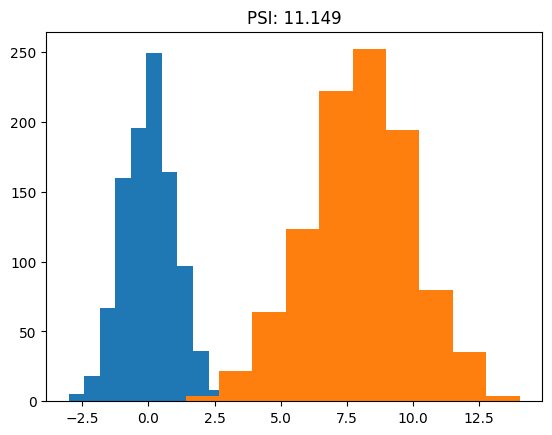

In [34]:
import matplotlib.pyplot as plt

expected = np.random.normal(0, 1, 1000)
actual = np.random.normal(8, 2, 1000)

psi = calculate_psi(expected, actual)
plt.hist(expected)
plt.hist(actual)
plt.title(f'PSI: {psi.round(3)}')
plt.show()

<Axes: xlabel='value', ylabel='Proportion'>

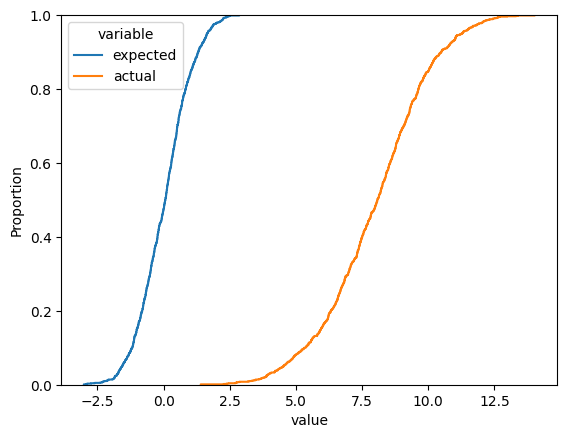

In [35]:
import seaborn as sns
df_plot = pd.DataFrame(zip(expected, actual), columns=['expected', 'actual'])
df_plot = df_plot.melt(value_vars=['expected', 'actual'])
sns.ecdfplot(data=df_plot, x='value', hue='variable')

Ok, ahora utilizando la librería de selección de features, esto sería:

In [36]:
from feature_engine.selection import DropHighPSIFeatures

# Notar que el split frac se utiliza para separar los datos
transformer = DropHighPSIFeatures(split_frac=0.6)
transformer.fit_transform(X_train.reset_index(drop=True))

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist
0,0.630,0.616,1,-8.128,0,0.0309,0.4630,0.040800,0.1730,0.5090,118.650,270773,4,The Rolling Stones
1,0.721,0.949,6,-5.685,1,0.2780,0.0495,0.000000,0.3270,0.8350,83.028,240093,4,Camp Lo
2,0.650,0.900,1,-4.099,0,0.3740,0.0252,0.000000,0.1760,0.6590,89.788,206493,4,Black Star
3,0.770,0.656,10,-11.169,0,0.2460,0.1100,0.000000,0.0793,0.7880,98.820,253413,4,Pete Rock & C.L. Smooth
4,0.617,0.771,10,-5.586,0,0.1120,0.0384,0.000003,0.1620,0.5530,180.002,267747,4,Daddy Yankee
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,0.518,0.575,5,-4.616,1,0.0302,0.0259,0.000000,0.1090,0.2090,120.019,340707,4,Harry Styles
647,0.684,0.714,2,-11.001,1,0.0495,0.2010,0.000000,0.0727,0.7630,123.377,383827,4,Harold Melvin & The Blue Notes
648,0.854,0.559,10,-2.516,0,0.0347,0.0083,0.513000,0.1350,0.6390,126.015,159048,4,Valentino Khan
649,0.720,0.823,0,-7.634,1,0.0268,0.0644,0.009480,0.3610,0.8540,120.747,260747,4,Kelly Marie


Revisamos el valor de PSI/CSI obtenido para cada uno:

In [37]:
transformer.psi_values_

{'danceability': 0.07362153753435291,
 'energy': 0.0798288725921034,
 'loudness': 0.08920073653814793,
 'speechiness': 0.04260774465910741,
 'acousticness': 0.06281781794996323,
 'instrumentalness': 0.0595263462482626,
 'liveness': 0.029507184369488827,
 'valence': 0.05613293150376942,
 'tempo': 0.11791828718097312,
 'duration_ms': 0.05168907676874426}

In [38]:
transformer.features_to_drop_

[]

Comparamos las distribuciones de alguna variable:

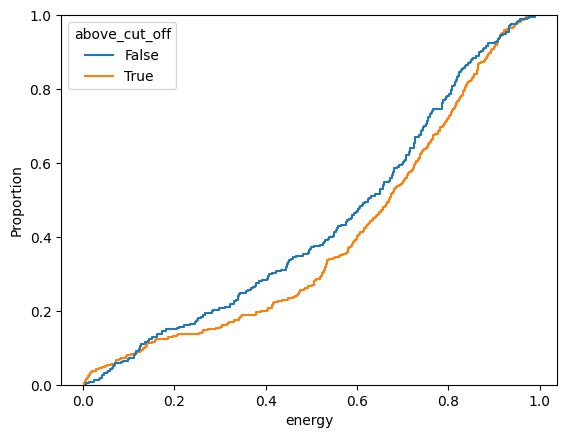

In [40]:
import seaborn as sns

X_train_example = X_train.reset_index(drop=None).copy()
X_train_example['above_cut_off'] = X_train_example.index < transformer.cut_off_
sns.ecdfplot(data=X_train_example, x='energy', hue='above_cut_off')
plt.show()

### Probe

<center>
<img src='https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F10f9a8f7-ce4d-46d5-8915-127b5a20d3e0_770x862.gif' width=350 />

Uno de los principales objetivos de la selección de features es eliminar el ruido del conjunto de datos. Una variable generada aleatoriamente, es decir, una feature de prueba, posee inherentemente un alto nivel de ruido. Por lo tanto, cualquier variable que demuestre ser menos importante que una feature de prueba se considera ruido y puede ser descartada del conjunto de datos.

En esta línea, un selector de features que cumple este objetivo es **Probe**, que se enfoca en seleccionar features dentro de un conjunto de datos que tienen un poder predictivo significativamente mayor que una variable aleatoria.

**Probe** genera una o más variables aleatorias basadas en los parámetros seleccionados por el usuario. Luego, el transformador deriva la importancia de cada feature y features de prueba. Finalmente, elimina las features que tienen una puntuación de importancia menor que la(s) feature(s) de prueba.

#### Pasos para la Selección

1. Crear una o más features aleatorias.
2. Entrenar un modelo de machine learning con todas las features, incluidas las aleatorias.
3. Derivar la importancia de las features para todas las variables.
4. Calcular la importancia promedio de las features aleatorias (solo si se utilizaron más de una).
5. Seleccionar las features cuya importancia sea mayor que la importancia de las variables aleatorias (paso 4).

Para realizar el ejemplo, utilizaremos `RandomForestClassifier()` como el estimador. Usaremos la precisión como el parámetro de evaluación y 5 como el parámetro `cv`, ambos utilizados en la validación cruzada.

En este ejemplo, introduciremos solo una feature aleatoria con una distribución normal. Por lo tanto, pasaremos 1 para el parámetro `n_probes` y `normal` como la distribución:

In [41]:
from sklearn.ensemble import RandomForestClassifier
from feature_engine.selection import ProbeFeatureSelection

In [43]:
# %%capture
sel = ProbeFeatureSelection(
    estimator=RandomForestClassifier(),
    variables=None,
    scoring="precision",
    n_probes=1,
    distribution="normal",
    cv=5,
    random_state=150
)

X_probe = sel.fit_transform(X_train, y_train)

Para revisar el comportamiento de la variable aleatoria anexada al dataset, realizamos:

In [44]:
sel.probe_features_.describe()

,gaussian_probe_0
count,651.000000
mean,0.001391
std,3.122366
min,-8.476446
25%,-2.142696
50%,0.052611
75%,2.186219
max,8.460121


Luego, si queremos revisar el ranking de la selección de features:

In [45]:
sel.feature_importances_

danceability        0.131761
energy              0.093635
loudness            0.102290
speechiness         0.125028
acousticness        0.105498
instrumentalness    0.075502
liveness            0.050809
valence             0.092012
tempo               0.097460
duration_ms         0.081959
gaussian_probe_0    0.044045
dtype: float64

Veamos ahora el caso si agregamos más de una variable aleatoria:

In [46]:
# %%capture
sel = ProbeFeatureSelection(
    estimator=RandomForestClassifier(),
    variables=None,
    scoring="precision",
    n_probes=3,
    distribution="all",
    cv=5,
    random_state=150,
    confirm_variables=False
)

X_probe = sel.fit(X_train, y_train)

In [47]:
sel.probe_features_.head()

,gaussian_probe_0,binary_probe_0,uniform_probe_0
0,-0.694150,0,0.101473
1,1.171840,0,0.537673
2,1.074892,1,0.251362
3,1.698733,1,0.611564
4,0.498702,1,0.669323


In [48]:
sel.feature_importances_

danceability        0.119557
energy              0.085010
loudness            0.099894
speechiness         0.119994
acousticness        0.100183
instrumentalness    0.074128
liveness            0.049885
valence             0.092806
tempo               0.092541
duration_ms         0.078066
gaussian_probe_0    0.040387
binary_probe_0      0.008048
uniform_probe_0     0.039501
dtype: float64

❓ Pregunta: ¿Podría utilizarse un algoritmo diferente a RandomForest?

### Scheme independent o Método de Filtro .

<center>
<img src='https://i.gifer.com/origin/c9/c9be3e27aac9ecddc6c7e64aad70d8df_w200.gif' width=350 />

Compara las características con las etiquetas a través de test estadísticos simples e ignora la relación entre las características en si. Para ocupar este tipo de técnicas se requiere una métrica y una estrategia

#### Métricas

- Varias métricas para clasificación: 
    - Anova (`f_classif`). La idea es calcular un estadístico F-score, el cuál indica que tan fácil es para un atributo distinguir entre clases. Más información [aquí](https://datascience.stackexchange.com/questions/74465/how-to-understand-anova-f-for-feature-selection-in-python-sklearn-selectkbest-w).
    - Mutual information (`mutual_info_classif`) es un estadístico que mide la independencia entre dos variables aleatorias. 0 indica independencia entre variables. Valores más altos indican mayor depencia. En general da mejores resultados que `f_classif`, pero su implementación es más lenta.
    - Chi squared (`chi2`) realiza un test estadístico $\chi^2$ que, al igual que la función anterior, mide la dependencia entre distintas variables. Sirve solo con variables categóricas (en OneHot) o conteos (como Bag of Words).
    
- Para regresión, se usan otro tipo de métricas especializadas en ellas.
- Referencia: [Univariate Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).

#### Estrategias

Definen como se seleccionarán las mejores características: 

- `SelectKBest` selecciona las features con los mejores valores. Hay que especificar el número de features que seleccionaremos.

- `SelectPercentile` selecciona el porcentaje con mejores valores. Hay que especificar con cuanto porcentaje quedarse.

#### Integrar la Selección de Características al Pipeline

La búsqueda de mejores características se realiza al momento de entrenar un pipeline. Luego, al momento de predecir, el selector de características simplemente descarta las características no utilizadas antes de pasar a la siguiente etapa. El siguiente ejemplo muestra lo anteriormente dicho:

In [49]:
from sklearn.feature_selection import (
    SelectKBest,
    SelectPercentile,
    f_classif,
    mutual_info_classif,
)

# Creamos nuestro baseline pipeline
selection_pipeline = Pipeline(
    steps=[
        ("Preprocessing", preprocessing),
        # Conservamos el 70% mejor según la métrica seleccionada
        ("Selection", SelectPercentile(f_classif, percentile=70)),
        ("Tree", DecisionTreeClassifier(random_state=42)),
    ]
)

train_and_evaluate(selection_pipeline)

Matriz de confusión: 

[[17  0  0  0  3  0  0  0  0]
 [ 0  9  1  1  0  1  1  1  3]
 [ 0  2  5  3  0  0  1  0  1]
 [ 0  0  1 17  0  1  1  0  0]
 [ 4  0  0  0  6  1  0  2  1]
 [ 0  0  3  1  1 11  0  2  2]
 [ 0  1  0  5  0  1 11  1  1]
 [ 0  3  1  0  1  1  2  9  3]
 [ 0  5  3  0  2  2  0  4  4]]

Reporte de Clasificación: 

              precision    recall  f1-score   support

     Clasica       0.81      0.85      0.83        20
       Disco       0.45      0.53      0.49        17
 Electronica       0.36      0.42      0.38        12
      Hiphop       0.63      0.85      0.72        20
        Jazz       0.46      0.43      0.44        14
         Pop       0.61      0.55      0.58        20
   Reggaeton       0.69      0.55      0.61        20
        Rock       0.47      0.45      0.46        20
 Rock latino       0.27      0.20      0.23        20

    accuracy                           0.55       163
   macro avg       0.53      0.54      0.53       163
weighted avg       0.54    

0.5275985814656051

In [50]:
# Creamos nuestro baseline pipeline
selection_pipeline = Pipeline(
    steps=[
        ("Preprocessing", preprocessing),
        ("Selection", SelectPercentile(f_classif, percentile=20)),
        ("Tree", DecisionTreeClassifier(random_state=42)),
    ]
)

train_and_evaluate(selection_pipeline)

Matriz de confusión: 

[[17  0  0  0  2  0  0  0  1]
 [ 0  9  1  1  0  1  2  0  3]
 [ 0  4  3  3  0  0  2  0  0]
 [ 0  0  0 17  0  1  1  1  0]
 [ 3  1  0  0  7  1  0  2  0]
 [ 0  1  2  0  0 13  1  2  1]
 [ 0  0  0  4  0  2 11  2  1]
 [ 0  3  3  0  1  1  1  8  3]
 [ 0  6  2  0  2  2  0  5  3]]

Reporte de Clasificación: 

              precision    recall  f1-score   support

     Clasica       0.85      0.85      0.85        20
       Disco       0.38      0.53      0.44        17
 Electronica       0.27      0.25      0.26        12
      Hiphop       0.68      0.85      0.76        20
        Jazz       0.58      0.50      0.54        14
         Pop       0.62      0.65      0.63        20
   Reggaeton       0.61      0.55      0.58        20
        Rock       0.40      0.40      0.40        20
 Rock latino       0.25      0.15      0.19        20

    accuracy                           0.54       163
   macro avg       0.52      0.53      0.52       163
weighted avg       0.53    

0.5160560843736506

In [51]:
# Creamos nuestro baseline pipeline
selection_pipeline = Pipeline(
    steps=[
        ("Preprocessing", preprocessing),
        ("Selection", SelectPercentile(mutual_info_classif, percentile=20)),
        ("Tree", DecisionTreeClassifier(random_state=42)),
    ]
)

train_and_evaluate(selection_pipeline)

Matriz de confusión: 

[[17  0  0  0  2  0  0  0  1]
 [ 0  7  1  2  0  1  1  1  4]
 [ 0  2  5  2  0  0  1  0  2]
 [ 0  0  1 17  0  1  1  0  0]
 [ 3  0  0  0  7  1  0  2  1]
 [ 0  0  2  1  1 12  0  3  1]
 [ 0  1  0  4  0  1 12  1  1]
 [ 0  4  1  0  0  2  1  8  4]
 [ 0  6  2  0  1  3  0  4  4]]

Reporte de Clasificación: 

              precision    recall  f1-score   support

     Clasica       0.85      0.85      0.85        20
       Disco       0.35      0.41      0.38        17
 Electronica       0.42      0.42      0.42        12
      Hiphop       0.65      0.85      0.74        20
        Jazz       0.64      0.50      0.56        14
         Pop       0.57      0.60      0.59        20
   Reggaeton       0.75      0.60      0.67        20
        Rock       0.42      0.40      0.41        20
 Rock latino       0.22      0.20      0.21        20

    accuracy                           0.55       163
   macro avg       0.54      0.54      0.54       163
weighted avg       0.55    

0.53522119179986

> **Pregunta: ❓** ¿Cómo elegir el mejor porcentaje de features por conservar? ¿Y la métrica?

In [50]:
selection_pipeline.steps[1][1]

SelectPercentile(percentile=20,
                 score_func=<function mutual_info_classif at 0x7f7e1544aa20>)

In [52]:
selection_pipeline.steps[1][1].percentile

20

In [52]:
f1 = []
for i in range(10, 101, 10):
    selection_pipeline.steps[1][1].percentile = i
    f1.append([i, train_and_evaluate(selection_pipeline, print_=False)])
f1 = np.array(f1)

px.line(
    x=f1[:, 0],
    y=f1[:, 1],
    title="F1 según cantidad de Features Conservadas",
    labels={"x": "Porcentaje de Features Conservadas", "y": "F1"},
)

## GridSearch

<center>
<img src='https://media3.giphy.com/media/42wQXwITfQbDGKqUP7/giphy.gif?cid=6c09b952u0a9kwn7ryl9mz4nhhp82i0lvayupiwrvd4lz1bw&ep=v1_gifs_search&rid=giphy.gif&ct=g' width=250 />

Si bien el ciclo anterior nos permitió encontrar el mejor valor para el porcentaje de la selección de atributos, es bastante trabajo implementarlo, pensando más aún que comunmente se quieren optimizar varias partes del pipeline y no solo un paso en específico.

En el caso anterior, un ejemplo de esto podría ser variar el porcentaje como la métrica usada, teniendo una malla de búsqueda del estilo:

| `f_classif` | `mutual_info_classif` |
|---|---|
| 10 | 10 |
| 20 | 20 |
| 30 | 30 |
| 40 | 40 |
| 50 | 50 |
| 60 | 60 |
| 70 | 70 |
| 80 | 80 |
| 90 | 90 |
| 100 | 100 |


Por esto, la idea es tener un mecanismo para el cual podamos pasarle una lista de hiperparámetros, que este lo pruebe todos y que retorne el mejor modelo. 
Este mecanismo en `scikit-learn` es conocido como Búsqueda de grilla o `Grid-search`.





### Encontrar los Parámetros Disponibles para Modificar

En general, cualquier clase de scikit-learn implementa la función `get_params`, la cual muestra los parámetros disponibles para probar y modificar.


In [53]:
SelectPercentile().get_params()

{'percentile': 10,
 'score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

Para el caso de una `Pipeline`, muestra las `steps` de la pipeline más los parámetros de cada una de las steps. 
Noten que los parámetros de cada `step` siguen la notación: `{nombre_step}__{parámetro_step}`

Ejemplo: Número de porcentajes que escogeremos - `Selection__percentile`



In [84]:
selection_pipeline = Pipeline(
    steps=[
        ("Preprocessing", preprocessing),
        ("Selection", SelectPercentile(f_classif, percentile=20)),
        ("Tree", DecisionTreeClassifier(random_state=42)),
    ]
)

selection_pipeline.get_params()

{'memory': None,
 'steps': [('Preprocessing',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('Scale', MinMaxScaler(),
                                    ['duration_ms', 'tempo', 'loudness',
                                     'time_signature']),
                                   ('One Hot Encoding',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    ['key', 'mode', 'artist', 'time_signature'])])),
  ('Selection', SelectPercentile(percentile=20)),
  ('Tree', DecisionTreeClassifier(random_state=42))],
 'verbose': False,
 'Preprocessing': ColumnTransformer(remainder='passthrough',
                   transformers=[('Scale', MinMaxScaler(),
                                  ['duration_ms', 'tempo', 'loudness',
                                   'time_signature']),
                                 ('One Hot Encoding',
      

La idea es definir un grilla de hiperparámetros para que GridSearch los explore y elija el mejor.

In [85]:
param_grid = [
    {"Selection__percentile": range(10, 101, 5)}
]
param_grid

[{'Selection__percentile': range(10, 101, 5)}]

Y luego invocar GridSearch con el Pipeline, la grilla de hiperparámetros, la métrica (pueden ver las métricas disponibles [aquí](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)) y la cantidad de cores de su CPU que deseen usar:

In [86]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(selection_pipeline, param_grid, n_jobs=-1, scoring="f1_macro")
train_and_evaluate(gs)

Matriz de confusión: 

[[17  0  0  0  3  0  0  0  0]
 [ 0  8  2  2  0  1  1  1  2]
 [ 0  1  6  3  1  0  1  0  0]
 [ 0  0  0 17  0  1  1  1  0]
 [ 2  0  0  0  7  1  0  3  1]
 [ 0  0  1  1  0 13  0  2  3]
 [ 0  1  0  5  0  1 11  1  1]
 [ 0  3  0  0  0  2  2 10  3]
 [ 0  5  3  0  1  2  0  4  5]]

Reporte de Clasificación: 

              precision    recall  f1-score   support

     Clasica       0.89      0.85      0.87        20
       Disco       0.44      0.47      0.46        17
 Electronica       0.50      0.50      0.50        12
      Hiphop       0.61      0.85      0.71        20
        Jazz       0.58      0.50      0.54        14
         Pop       0.62      0.65      0.63        20
   Reggaeton       0.69      0.55      0.61        20
        Rock       0.45      0.50      0.48        20
 Rock latino       0.33      0.25      0.29        20

    accuracy                           0.58       163
   macro avg       0.57      0.57      0.56       163
weighted avg       0.57    

0.5647660905790988

In [87]:
gs.best_params_

{'Selection__percentile': 65}

Los resultados de la exploración de grilla los pueden visualizar así: 

In [58]:
gs.best_estimator_

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Scale', MinMaxScaler(),
                                                  ['duration_ms', 'tempo',
                                                   'loudness',
                                                   'time_signature']),
                                                 ('One Hot Encoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['key', 'mode', 'artist',
                                                   'time_signature'])])),
                ('Selection', SelectPercentile(percentile=65)),
                ('Tree', DecisionTreeClassifier(random_state=42))])

#### Ejemplo de Uso para Predicción de GridSearch

In [59]:
# sacamos el vector de los atributos desde las features
gs.predict(X_test)

array(['Electronica', 'Rock latino', 'Reggaeton', 'Electronica',
       'Clasica', 'Hiphop', 'Electronica', 'Hiphop', 'Hiphop', 'Hiphop',
       'Pop', 'Hiphop', 'Rock latino', 'Jazz', 'Clasica', 'Rock latino',
       'Pop', 'Rock', 'Disco', 'Rock', 'Rock', 'Clasica', 'Electronica',
       'Pop', 'Clasica', 'Reggaeton', 'Hiphop', 'Rock', 'Rock latino',
       'Reggaeton', 'Reggaeton', 'Rock latino', 'Disco', 'Disco',
       'Hiphop', 'Clasica', 'Rock', 'Disco', 'Jazz', 'Rock latino',
       'Hiphop', 'Rock latino', 'Rock', 'Disco', 'Clasica', 'Rock',
       'Reggaeton', 'Rock latino', 'Reggaeton', 'Rock latino', 'Disco',
       'Hiphop', 'Reggaeton', 'Reggaeton', 'Pop', 'Hiphop', 'Rock',
       'Rock latino', 'Reggaeton', 'Reggaeton', 'Rock', 'Pop', 'Pop',
       'Jazz', 'Disco', 'Jazz', 'Hiphop', 'Pop', 'Clasica', 'Disco',
       'Jazz', 'Hiphop', 'Rock', 'Hiphop', 'Rock latino', 'Rock',
       'Electronica', 'Jazz', 'Hiphop', 'Clasica', 'Disco', 'Pop',
       'Reggaeton', 'Disco', 'H

> **Pregunta ❓**: ¿Y si ahora quiero usar otra métrica univariada para seleccionar atributos?

Por ejemplo, [`Mutual information`](https://en.wikipedia.org/wiki/Mutual_information)
Vamos nuevamente a buscar el nombre del atributo que queremos modificar y ejecutamos nuevamente grid-search.

In [88]:

selection_pipeline = Pipeline(
    steps=[
        ("Preprocessing", preprocessing),
        ("Selection", SelectPercentile(mutual_info_classif, percentile=20)),
        ("Tree", DecisionTreeClassifier(random_state=42)),
    ]
)

param_grid = [
    {
        "Selection__percentile": range(5, 101, 5),
        "Selection__score_func": [f_classif, mutual_info_classif],
    }
]

In [89]:
gs2 = GridSearchCV(selection_pipeline, param_grid, n_jobs=-1, scoring="f1_macro")
train_and_evaluate(gs2)

Matriz de confusión: 

[[17  0  0  0  3  0  0  0  0]
 [ 0  9  1  1  0  1  1  1  3]
 [ 0  1  5  3  1  0  1  1  0]
 [ 0  0  0 17  0  1  1  0  1]
 [ 4  1  0  0  6  1  0  2  0]
 [ 0  3  0  1  0 12  0  2  2]
 [ 0  0  0  5  0  2 11  1  1]
 [ 0  3  0  0  0  2  2  8  5]
 [ 0  8  3  0  1  3  0  1  4]]

Reporte de Clasificación: 

              precision    recall  f1-score   support

     Clasica       0.81      0.85      0.83        20
       Disco       0.36      0.53      0.43        17
 Electronica       0.56      0.42      0.48        12
      Hiphop       0.63      0.85      0.72        20
        Jazz       0.55      0.43      0.48        14
         Pop       0.55      0.60      0.57        20
   Reggaeton       0.69      0.55      0.61        20
        Rock       0.50      0.40      0.44        20
 Rock latino       0.25      0.20      0.22        20

    accuracy                           0.55       163
   macro avg       0.54      0.54      0.53       163
weighted avg       0.55    

0.5318489779967033

In [91]:
gs2.best_score_

0.5521556196958343

In [90]:
gs2.best_params_

{'Selection__percentile': 85,
 'Selection__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_classif(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>}

> **Pregunta ❓**: ¿Podemos entonces también cambiar el clasificador y probar varios tipos?
    

### Probando con más clasificadores 

Efectivamente, la notación permite generar distintas grillas de búsqueda para distintos clasificadores a través de la definición de distintos diccionarios dentro de la lista que se le provee a GridSearch:


```
[
    # grilla 1
    {
     'modelo' : [Modelo1()],
     'modelo__param1': ...
    },
    # grilla 2
    {
     'modelo' : [Modelo1()],
     'modelo__param1': ...
    }, 
    ...

]
```

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

pipe = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("selection", SelectPercentile(f_classif)),
        ("model", KNeighborsClassifier()),
    ]
)

pipe.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('Scale', MinMaxScaler(),
                                    ['duration_ms', 'tempo', 'loudness',
                                     'time_signature']),
                                   ('One Hot Encoding',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    ['key', 'mode', 'artist', 'time_signature'])])),
  ('selection', SelectPercentile()),
  ('model', KNeighborsClassifier())],
 'verbose': False,
 'preprocessing': ColumnTransformer(remainder='passthrough',
                   transformers=[('Scale', MinMaxScaler(),
                                  ['duration_ms', 'tempo', 'loudness',
                                   'time_signature']),
                                 ('One Hot Encoding',
                                  O

In [53]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [65]:
grid = [
    # grilla 1: tree
    {
        "selection__percentile": range(10, 101, 10),
        "model": [DecisionTreeClassifier()],
        "model__criterion": ["gini", "entropy"],
    },
    # grilla 2: knn
    {
        "selection__percentile": range(10, 101, 10),
        "model": [KNeighborsClassifier()],
        "model__n_neighbors": [2, 4, 5, 10],
    },
    # grilla 3: random forest
    {
        "model": [RandomForestClassifier()],
        "model__criterion": ["gini", "entropy"],
        "model__bootstrap": [True, False],
    },
]

In [66]:
gs3 = GridSearchCV(pipe, grid, n_jobs=-1, scoring="f1_macro").fit(X_train, y_train)

In [67]:
train_and_evaluate(gs3)

Matriz de confusión: 

[[18  0  0  0  2  0  0  0  0]
 [ 0 13  2  1  0  0  0  1  0]
 [ 0  1  9  0  0  0  1  1  0]
 [ 0  0  0 17  0  0  3  0  0]
 [ 4  0  0  0  8  0  0  0  2]
 [ 1  1  0  0  1 16  0  1  0]
 [ 0  2  0  3  0  1 14  0  0]
 [ 0  4  2  1  1  0  1  8  3]
 [ 0  6  2  0  1  3  0  4  4]]

Reporte de Clasificación: 

              precision    recall  f1-score   support

     Clasica       0.78      0.90      0.84        20
       Disco       0.48      0.76      0.59        17
 Electronica       0.60      0.75      0.67        12
      Hiphop       0.77      0.85      0.81        20
        Jazz       0.62      0.57      0.59        14
         Pop       0.80      0.80      0.80        20
   Reggaeton       0.74      0.70      0.72        20
        Rock       0.53      0.40      0.46        20
 Rock latino       0.44      0.20      0.28        20

    accuracy                           0.66       163
   macro avg       0.64      0.66      0.64       163
weighted avg       0.65    

0.638650567341648

In [68]:
gs3.best_params_

{'model': RandomForestClassifier(),
 'model__bootstrap': True,
 'model__criterion': 'entropy'}

## Mejoras a GridSearch

### HalvingGridSearchCV

El funcionamiento de HalvingGridSearchCV se basa en un enfoque iterativo y progresivo. Inicialmente, explora muchas combinaciones de hiperparámetros utilizando una pequeña porción del conjunto de datos. Esto permite evaluar rápidamente cuáles combinaciones tienen más potencial sin invertir demasiado tiempo y recursos en el proceso inicial. A medida que avanza, el algoritmo elimina las combinaciones menos prometedoras y retiene solo las mejores. En cada ronda sucesiva, aumenta gradualmente la cantidad de datos y recursos asignados a las combinaciones que siguen en la competencia.

<br>

<div align='center'>
<img src="../../recursos/2025-01/10-Feature_selection/halving_2.PNG?raw=true" width=500/>
</div>

In [82]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

selection_pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessing),
        ("selection", SelectPercentile(mutual_info_classif, percentile=20)),
        ("model", RandomForestClassifier()),
    ]
)

param_grid = [
    {
        "selection__percentile": range(5, 101, 10),
        "model__criterion": ["gini", "entropy"],
        "model__bootstrap": [True, False],
    }
]

hgs = HalvingGridSearchCV(selection_pipeline, param_grid, n_jobs=-1, scoring='f1_macro')

train_and_evaluate(hgs)

Matriz de confusión: 

[[18  0  0  0  2  0  0  0  0]
 [ 0 13  1  1  0  0  1  1  0]
 [ 0  1  7  1  0  0  1  0  2]
 [ 0  0  0 18  0  0  2  0  0]
 [ 2  0  0  0 10  0  0  1  1]
 [ 0  0  1  0  0 18  0  0  1]
 [ 0  1  0  4  0  0 15  0  0]
 [ 0  2  1  0  2  0  2  8  5]
 [ 0  3  2  0  1  3  1  4  6]]

Reporte de Clasificación: 

              precision    recall  f1-score   support

     Clasica       0.90      0.90      0.90        20
       Disco       0.65      0.76      0.70        17
 Electronica       0.58      0.58      0.58        12
      Hiphop       0.75      0.90      0.82        20
        Jazz       0.67      0.71      0.69        14
         Pop       0.86      0.90      0.88        20
   Reggaeton       0.68      0.75      0.71        20
        Rock       0.57      0.40      0.47        20
 Rock latino       0.40      0.30      0.34        20

    accuracy                           0.69       163
   macro avg       0.67      0.69      0.68       163
weighted avg       0.68    

0.6777392110618252

### Optuna

![](https://optuna.readthedocs.io/en/stable/_static/optuna-logo.png)

Optuna es una biblioteca de código abierto diseñada para la optimización automática de hiperparámetros y la búsqueda de configuraciones óptimas de algoritmos de aprendizaje automático. Su objetivo es ayudar a los científicos de datos y los ingenieros a encontrar la mejor combinación de hiperparámetros para un modelo de aprendizaje automático dado, lo que puede mejorar significativamente el rendimiento de dicho modelo. Optuna se basa en técnicas de optimización bayesiana y se ha convertido en una herramienta popular en el campo del aprendizaje automático.

En resumidas cuentas optuna:

1. **Definición del espacio de búsqueda**: En primer lugar, se debe definir un espacio de búsqueda que incluya los hiperparámetros que se desean optimizar y sus rangos de valores posibles. Estos hiperparámetros pueden incluir la tasa de aprendizaje, el número de capas ocultas en una red neuronal, el número de árboles en un bosque aleatorio, etc.

2. **Función objetivo**: Debes definir una función objetivo que toma un conjunto de hiperparámetros como entrada y evalúa el rendimiento del modelo de aprendizaje automático utilizando esos hiperparámetros en un conjunto de datos de validación o prueba. Esta función debe ser la que deseas maximizar o minimizar, dependiendo de tus objetivos (por ejemplo, maximizar la precisión del modelo).

3. **Optimización bayesiana**: Optuna utiliza técnicas de optimización bayesiana para explorar el espacio de búsqueda de manera eficiente. Comienza evaluando un conjunto inicial de hiperparámetros de forma aleatoria y, a medida que se acumulan más evaluaciones, utiliza un modelo probabilístico para predecir cuáles podrían ser las mejores combinaciones de hiperparámetros para explorar a continuación. Esto permite una búsqueda más inteligente y eficiente en lugar de una búsqueda exhaustiva.

4. **Criterios de parada**: Puedes definir criterios de parada para detener la búsqueda una vez que se alcanza un cierto nivel de rendimiento o se supera un número máximo de evaluaciones.

5. **Resultados y recomendaciones**: Una vez que la búsqueda de hiperparámetros finaliza, Optuna te proporciona la mejor configuración de hiperparámetros encontrada, así como el valor óptimo de la función objetivo.

Optuna se ha convertido en una herramienta valiosa en la comunidad de aprendizaje automático y ha demostrado ser eficaz para encontrar configuraciones óptimas de hiperparámetros en una amplia variedad de escenarios. Su enfoque basado en la optimización bayesiana ayuda a ahorrar tiempo y recursos en comparación con una búsqueda exhaustiva o aleatoria de hiperparámetros.

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*7GM-K-Xu6ui5XasY6DL1Xw.png)

La optimización bayesiana es un enfoque que se utiliza para encontrar la mejor solución de una función objetivo desconocida, teniendo en cuenta la incertidumbre. En términos simples, puedes pensar en ella como un método para buscar la mejor respuesta en un espacio de posibles soluciones de manera eficiente y sistemática, incluso cuando no tienes un conocimiento completo de cómo funciona la función que estás tratando de optimizar.

#### Tree-structured Parzen Estimator (TPE) 

![](https://tech.preferred.jp/wp-content/uploads/2020/10/image4-2.png)

1. Modelo probabilístico: TPE se basa en la construcción de dos modelos probabilísticos, uno para la función objetivo (que deseas optimizar) y otro para la función de probabilidad condicional. El modelo de probabilidad condicional se divide en dos partes: una que modela los puntos de exploración (evaluaciones donde los hiperparámetros se ajustan para buscar nuevos puntos) y otra que modela los puntos de explotación (evaluaciones donde los hiperparámetros se ajustan para maximizar la función objetivo en las áreas prometedoras).

2. Función de probabilidad condicional: La función de probabilidad condicional calcula la probabilidad de que un conjunto dado de hiperparámetros sea mejor que otro conjunto. La optimización se basa en encontrar los puntos que maximizan esta probabilidad.

3. Balance entre exploración y explotación: TPE equilibra la exploración y la explotación de manera eficiente. Durante la búsqueda, se enfoca en explorar nuevas áreas del espacio de hiperparámetros mientras también se explotan las áreas prometedoras donde se espera encontrar mejores configuraciones.

4. Ajuste continuo del modelo: A medida que se recopilan más datos de evaluación, el modelo de TPE se ajusta continuamente para reflejar mejor la función objetivo y la probabilidad condicional. Esto permite una búsqueda cada vez más precisa a medida que se acumulan más evaluaciones.

![](https://tech.preferred.jp/wp-content/uploads/2020/10/image3.gif)

In [54]:
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances

In [55]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [56]:
# Define your objective function to maximize aucpr
def objective_function(trial):
    # Split into features and target
    le = LabelEncoder()
    y = le.fit_transform(df.loc[:, "genre"])
    X = df.drop(columns=["genre", "id", "name", "artist"]).astype(float)

    # Split into train and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Define the hyperparameters to tune
    params = {
        "objective": "multi:softmax",
        "eval_metric": "mlogloss",
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
        "gamma": trial.suggest_float("gamma", 0, 1),
        "n_estimators": trial.suggest_int("n_estimators", 10, 300),
    }

    # Train the XGBoost model with prunning
    pruning_callback = optuna.integration.XGBoostPruningCallback(
        trial, observation_key="validation_1-mlogloss"
    )
    model = XGBClassifier(seed=42, **params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=10,
        callbacks=[pruning_callback],
    )

    # Predict and evaluate the model
    yhat = model.predict(X_valid)
    f1 = f1_score(y_valid, yhat, average='weighted')

    return f1

Notar que el prunning permitirá "podar" todos aquellos intentos que tienden a disminuir el desempeño final del modelo:

<center>
<img src='https://editor.analyticsvidhya.com/uploads/58727o1.png' width=350 />

In [57]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_function, n_trials=25)

[I 2025-04-23 17:30:53,795] A new study created in memory with name: no-name-ac6bbc48-0000-4fcc-b8c1-2d48a816c647


[0]	validation_0-mlogloss:2.19529	validation_1-mlogloss:2.19575
[1]	validation_0-mlogloss:2.19331	validation_1-mlogloss:2.19418
[2]	validation_0-mlogloss:2.19136	validation_1-mlogloss:2.19270
[3]	validation_0-mlogloss:2.18942	validation_1-mlogloss:2.19122
[4]	validation_0-mlogloss:2.18755	validation_1-mlogloss:2.18974
[5]	validation_0-mlogloss:2.18573	validation_1-mlogloss:2.18834
[6]	validation_0-mlogloss:2.18388	validation_1-mlogloss:2.18693
[7]	validation_0-mlogloss:2.18203	validation_1-mlogloss:2.18545
[8]	validation_0-mlogloss:2.18025	validation_1-mlogloss:2.18402
[9]	validation_0-mlogloss:2.17834	validation_1-mlogloss:2.18260
[10]	validation_0-mlogloss:2.17645	validation_1-mlogloss:2.18114
[11]	validation_0-mlogloss:2.17470	validation_1-mlogloss:2.17990
[12]	validation_0-mlogloss:2.17296	validation_1-mlogloss:2.17855
[13]	validation_0-mlogloss:2.17102	validation_1-mlogloss:2.17704
[14]	validation_0-mlogloss:2.16916	validation_1-mlogloss:2.17556
[15]	validation_0-mlogloss:2.16731	

[I 2025-04-23 17:31:10,461] Trial 0 finished with value: 0.5939467638700767 and parameters: {'max_depth': 7, 'learning_rate': 0.001026195369067858, 'subsample': 0.9746911894355179, 'colsample_bytree': 0.8455042408865056, 'min_child_weight': 5, 'gamma': 0.736115302016241, 'n_estimators': 85}. Best is trial 0 with value: 0.5939467638700767.


[0]	validation_0-mlogloss:2.10526	validation_1-mlogloss:2.12326
[1]	validation_0-mlogloss:2.02496	validation_1-mlogloss:2.06116
[2]	validation_0-mlogloss:1.94654	validation_1-mlogloss:2.00082
[3]	validation_0-mlogloss:1.87836	validation_1-mlogloss:1.95014
[4]	validation_0-mlogloss:1.81475	validation_1-mlogloss:1.90309
[5]	validation_0-mlogloss:1.75438	validation_1-mlogloss:1.85262
[6]	validation_0-mlogloss:1.70023	validation_1-mlogloss:1.81175
[7]	validation_0-mlogloss:1.65103	validation_1-mlogloss:1.77276
[8]	validation_0-mlogloss:1.60166	validation_1-mlogloss:1.73228
[9]	validation_0-mlogloss:1.55835	validation_1-mlogloss:1.70461
[10]	validation_0-mlogloss:1.51373	validation_1-mlogloss:1.67010
[11]	validation_0-mlogloss:1.47440	validation_1-mlogloss:1.64265
[12]	validation_0-mlogloss:1.43617	validation_1-mlogloss:1.61650
[13]	validation_0-mlogloss:1.39797	validation_1-mlogloss:1.58898
[14]	validation_0-mlogloss:1.36110	validation_1-mlogloss:1.55996
[15]	validation_0-mlogloss:1.32815	

[I 2025-04-23 17:31:19,572] Trial 1 finished with value: 0.6718085918258437 and parameters: {'max_depth': 7, 'learning_rate': 0.05512176820326873, 'subsample': 0.6768795623258597, 'colsample_bytree': 0.601636815105411, 'min_child_weight': 4, 'gamma': 0.39958326277201184, 'n_estimators': 80}. Best is trial 1 with value: 0.6718085918258437.


[0]	validation_0-mlogloss:2.10798	validation_1-mlogloss:2.13254
[1]	validation_0-mlogloss:2.02494	validation_1-mlogloss:2.06919
[2]	validation_0-mlogloss:1.94872	validation_1-mlogloss:2.00705
[3]	validation_0-mlogloss:1.87741	validation_1-mlogloss:1.95122
[4]	validation_0-mlogloss:1.81323	validation_1-mlogloss:1.90101
[5]	validation_0-mlogloss:1.75551	validation_1-mlogloss:1.85778
[6]	validation_0-mlogloss:1.70025	validation_1-mlogloss:1.81412
[7]	validation_0-mlogloss:1.64607	validation_1-mlogloss:1.77169
[8]	validation_0-mlogloss:1.59739	validation_1-mlogloss:1.73475
[9]	validation_0-mlogloss:1.55138	validation_1-mlogloss:1.70066
[10]	validation_0-mlogloss:1.50694	validation_1-mlogloss:1.67026
[11]	validation_0-mlogloss:1.46683	validation_1-mlogloss:1.64073
[12]	validation_0-mlogloss:1.42716	validation_1-mlogloss:1.61213
[13]	validation_0-mlogloss:1.38823	validation_1-mlogloss:1.58533
[14]	validation_0-mlogloss:1.35208	validation_1-mlogloss:1.56006
[15]	validation_0-mlogloss:1.31901	

[I 2025-04-23 17:31:33,690] Trial 2 finished with value: 0.6815665754159423 and parameters: {'max_depth': 6, 'learning_rate': 0.05301200304483785, 'subsample': 0.9805711811633279, 'colsample_bytree': 0.8512856865080842, 'min_child_weight': 7, 'gamma': 0.35802233805629313, 'n_estimators': 112}. Best is trial 2 with value: 0.6815665754159423.


[0]	validation_0-mlogloss:2.18011	validation_1-mlogloss:2.18355
[1]	validation_0-mlogloss:2.16275	validation_1-mlogloss:2.17158
[2]	validation_0-mlogloss:2.14508	validation_1-mlogloss:2.15697
[3]	validation_0-mlogloss:2.12860	validation_1-mlogloss:2.14565
[4]	validation_0-mlogloss:2.11225	validation_1-mlogloss:2.13413
[5]	validation_0-mlogloss:2.09623	validation_1-mlogloss:2.12194
[6]	validation_0-mlogloss:2.08117	validation_1-mlogloss:2.11041
[7]	validation_0-mlogloss:2.06685	validation_1-mlogloss:2.10068
[8]	validation_0-mlogloss:2.05199	validation_1-mlogloss:2.08952
[9]	validation_0-mlogloss:2.03745	validation_1-mlogloss:2.07943
[10]	validation_0-mlogloss:2.02256	validation_1-mlogloss:2.06847
[11]	validation_0-mlogloss:2.00870	validation_1-mlogloss:2.05823
[12]	validation_0-mlogloss:1.99481	validation_1-mlogloss:2.04797
[13]	validation_0-mlogloss:1.98059	validation_1-mlogloss:2.03753
[14]	validation_0-mlogloss:1.96629	validation_1-mlogloss:2.02697
[15]	validation_0-mlogloss:1.95337	

[I 2025-04-23 17:31:46,230] Trial 3 finished with value: 0.6697922264365349 and parameters: {'max_depth': 8, 'learning_rate': 0.009149285686098777, 'subsample': 0.9302791300781535, 'colsample_bytree': 0.6143390989599504, 'min_child_weight': 3, 'gamma': 0.8420552219870738, 'n_estimators': 106}. Best is trial 2 with value: 0.6815665754159423.


[0]	validation_0-mlogloss:2.18926	validation_1-mlogloss:2.19142
[1]	validation_0-mlogloss:2.18109	validation_1-mlogloss:2.18513
[2]	validation_0-mlogloss:2.17300	validation_1-mlogloss:2.17878
[3]	validation_0-mlogloss:2.16518	validation_1-mlogloss:2.17274
[4]	validation_0-mlogloss:2.15758	validation_1-mlogloss:2.16686
[5]	validation_0-mlogloss:2.15010	validation_1-mlogloss:2.16093
[6]	validation_0-mlogloss:2.14257	validation_1-mlogloss:2.15517
[7]	validation_0-mlogloss:2.13523	validation_1-mlogloss:2.14966
[8]	validation_0-mlogloss:2.12801	validation_1-mlogloss:2.14405
[9]	validation_0-mlogloss:2.12047	validation_1-mlogloss:2.13809
[10]	validation_0-mlogloss:2.11343	validation_1-mlogloss:2.13276
[11]	validation_0-mlogloss:2.10646	validation_1-mlogloss:2.12811
[12]	validation_0-mlogloss:2.09930	validation_1-mlogloss:2.12242
[13]	validation_0-mlogloss:2.09175	validation_1-mlogloss:2.11654
[14]	validation_0-mlogloss:2.08448	validation_1-mlogloss:2.11091
[15]	validation_0-mlogloss:2.07751	

[I 2025-04-23 17:31:56,702] Trial 4 finished with value: 0.6492665105368001 and parameters: {'max_depth': 6, 'learning_rate': 0.003931057153459447, 'subsample': 0.9625840477789602, 'colsample_bytree': 0.8147860863455811, 'min_child_weight': 3, 'gamma': 0.5247793295033888, 'n_estimators': 142}. Best is trial 2 with value: 0.6815665754159423.
[I 2025-04-23 17:31:56,851] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2025-04-23 17:31:56,896] Trial 6 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:2.19082	validation_1-mlogloss:2.19172
[1]	validation_0-mlogloss:2.18458	validation_1-mlogloss:2.18724
[2]	validation_0-mlogloss:2.17836	validation_1-mlogloss:2.18257
[3]	validation_0-mlogloss:2.17230	validation_1-mlogloss:2.17756
[4]	validation_0-mlogloss:2.16608	validation_1-mlogloss:2.17253
[5]	validation_0-mlogloss:2.16001	validation_1-mlogloss:2.16817
[6]	validation_0-mlogloss:2.15392	validation_1-mlogloss:2.16341
[7]	validation_0-mlogloss:2.14880	validation_1-mlogloss:2.15948
[8]	validation_0-mlogloss:2.14293	validation_1-mlogloss:2.15454
[9]	validation_0-mlogloss:2.13720	validation_1-mlogloss:2.15017
[10]	validation_0-mlogloss:2.13109	validation_1-mlogloss:2.14540
[11]	validation_0-mlogloss:2.12523	validation_1-mlogloss:2.14129
[12]	validation_0-mlogloss:2.11950	validation_1-mlogloss:2.13698
[13]	validation_0-mlogloss:2.11331	validation_1-mlogloss:2.13211
[14]	validation_0-mlogloss:2.10726	validation_1-mlogloss:2.12707
[15]	validation_0-mlogloss:2.10161	

[I 2025-04-23 17:31:57,968] Trial 7 finished with value: 0.6290070554336488 and parameters: {'max_depth': 4, 'learning_rate': 0.0036598038052029795, 'subsample': 0.5066157592377596, 'colsample_bytree': 0.6882593051232089, 'min_child_weight': 1, 'gamma': 0.8066407960345625, 'n_estimators': 31}. Best is trial 2 with value: 0.6815665754159423.


[0]	validation_0-mlogloss:2.16404	validation_1-mlogloss:2.17111


[I 2025-04-23 17:31:58,018] Trial 8 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:2.07132	validation_1-mlogloss:2.09433


[I 2025-04-23 17:31:58,055] Trial 9 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:2.16245	validation_1-mlogloss:2.16707


[I 2025-04-23 17:31:58,145] Trial 10 pruned. Trial was pruned at iteration 0.
[I 2025-04-23 17:31:58,235] Trial 11 pruned. Trial was pruned at iteration 0.
[I 2025-04-23 17:31:58,337] Trial 12 pruned. Trial was pruned at iteration 0.
[I 2025-04-23 17:31:58,418] Trial 13 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:2.17826	validation_1-mlogloss:2.18158


[I 2025-04-23 17:31:58,555] Trial 14 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:2.04735	validation_1-mlogloss:2.07071


[I 2025-04-23 17:31:58,676] Trial 15 pruned. Trial was pruned at iteration 0.
[I 2025-04-23 17:31:58,735] Trial 16 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:2.17883	validation_1-mlogloss:2.18198


[I 2025-04-23 17:31:58,901] Trial 17 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:2.18574	validation_1-mlogloss:2.18782
[1]	validation_0-mlogloss:2.17424	validation_1-mlogloss:2.17969
[2]	validation_0-mlogloss:2.16302	validation_1-mlogloss:2.17167
[3]	validation_0-mlogloss:2.15235	validation_1-mlogloss:2.16262
[4]	validation_0-mlogloss:2.14183	validation_1-mlogloss:2.15543
[5]	validation_0-mlogloss:2.13137	validation_1-mlogloss:2.14786
[6]	validation_0-mlogloss:2.12108	validation_1-mlogloss:2.13993
[7]	validation_0-mlogloss:2.11129	validation_1-mlogloss:2.13223
[8]	validation_0-mlogloss:2.10101	validation_1-mlogloss:2.12364
[9]	validation_0-mlogloss:2.09098	validation_1-mlogloss:2.11607
[10]	validation_0-mlogloss:2.08077	validation_1-mlogloss:2.10849
[11]	validation_0-mlogloss:2.07140	validation_1-mlogloss:2.10088
[12]	validation_0-mlogloss:2.06110	validation_1-mlogloss:2.09204
[13]	validation_0-mlogloss:2.05127	validation_1-mlogloss:2.08476
[14]	validation_0-mlogloss:2.04149	validation_1-mlogloss:2.07713
[15]	validation_0-mlogloss:2.03190	

[I 2025-04-23 17:32:09,199] Trial 18 finished with value: 0.6715176529319908 and parameters: {'max_depth': 5, 'learning_rate': 0.00604642047271572, 'subsample': 0.5749843530052722, 'colsample_bytree': 0.9301216538017193, 'min_child_weight': 2, 'gamma': 0.3973563968488242, 'n_estimators': 187}. Best is trial 2 with value: 0.6815665754159423.


[0]	validation_0-mlogloss:2.19540	validation_1-mlogloss:2.19570
[1]	validation_0-mlogloss:2.19351	validation_1-mlogloss:2.19429
[2]	validation_0-mlogloss:2.19161	validation_1-mlogloss:2.19282
[3]	validation_0-mlogloss:2.18978	validation_1-mlogloss:2.19145
[4]	validation_0-mlogloss:2.18798	validation_1-mlogloss:2.19008
[5]	validation_0-mlogloss:2.18620	validation_1-mlogloss:2.18864
[6]	validation_0-mlogloss:2.18444	validation_1-mlogloss:2.18720
[7]	validation_0-mlogloss:2.18282	validation_1-mlogloss:2.18599
[8]	validation_0-mlogloss:2.18107	validation_1-mlogloss:2.18456
[9]	validation_0-mlogloss:2.17936	validation_1-mlogloss:2.18330
[10]	validation_0-mlogloss:2.17756	validation_1-mlogloss:2.18181
[11]	validation_0-mlogloss:2.17584	validation_1-mlogloss:2.18053
[12]	validation_0-mlogloss:2.17411	validation_1-mlogloss:2.17916
[13]	validation_0-mlogloss:2.17241	validation_1-mlogloss:2.17787
[14]	validation_0-mlogloss:2.17058	validation_1-mlogloss:2.17651
[15]	validation_0-mlogloss:2.16888	

[I 2025-04-23 17:32:26,827] Trial 19 finished with value: 0.6560150169630597 and parameters: {'max_depth': 6, 'learning_rate': 0.0010687281982040974, 'subsample': 0.8265614161978027, 'colsample_bytree': 0.566380887614634, 'min_child_weight': 4, 'gamma': 0.17795575091769172, 'n_estimators': 179}. Best is trial 2 with value: 0.6815665754159423.
[I 2025-04-23 17:32:26,877] Trial 20 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:2.18764	validation_1-mlogloss:2.18980
[1]	validation_0-mlogloss:2.17824	validation_1-mlogloss:2.18326
[2]	validation_0-mlogloss:2.16913	validation_1-mlogloss:2.17652
[3]	validation_0-mlogloss:2.16030	validation_1-mlogloss:2.16953
[4]	validation_0-mlogloss:2.15184	validation_1-mlogloss:2.16334
[5]	validation_0-mlogloss:2.14333	validation_1-mlogloss:2.15703
[6]	validation_0-mlogloss:2.13467	validation_1-mlogloss:2.15004
[7]	validation_0-mlogloss:2.12657	validation_1-mlogloss:2.14347
[8]	validation_0-mlogloss:2.11807	validation_1-mlogloss:2.13665
[9]	validation_0-mlogloss:2.10965	validation_1-mlogloss:2.12995
[10]	validation_0-mlogloss:2.10115	validation_1-mlogloss:2.12357
[11]	validation_0-mlogloss:2.09303	validation_1-mlogloss:2.11723
[12]	validation_0-mlogloss:2.08462	validation_1-mlogloss:2.11066
[13]	validation_0-mlogloss:2.07617	validation_1-mlogloss:2.10446
[14]	validation_0-mlogloss:2.06809	validation_1-mlogloss:2.09867
[15]	validation_0-mlogloss:2.06007	

[I 2025-04-23 17:32:37,748] Trial 21 finished with value: 0.6712489431964345 and parameters: {'max_depth': 5, 'learning_rate': 0.00497555670647086, 'subsample': 0.5779207287642929, 'colsample_bytree': 0.916282788389248, 'min_child_weight': 2, 'gamma': 0.35586607235621875, 'n_estimators': 181}. Best is trial 2 with value: 0.6815665754159423.
[I 2025-04-23 17:32:37,898] Trial 22 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:2.19283	validation_1-mlogloss:2.19382
[1]	validation_0-mlogloss:2.18833	validation_1-mlogloss:2.19046
[2]	validation_0-mlogloss:2.18388	validation_1-mlogloss:2.18741
[3]	validation_0-mlogloss:2.17949	validation_1-mlogloss:2.18397
[4]	validation_0-mlogloss:2.17540	validation_1-mlogloss:2.18083
[5]	validation_0-mlogloss:2.17128	validation_1-mlogloss:2.17780
[6]	validation_0-mlogloss:2.16707	validation_1-mlogloss:2.17461
[7]	validation_0-mlogloss:2.16299	validation_1-mlogloss:2.17149
[8]	validation_0-mlogloss:2.15881	validation_1-mlogloss:2.16810
[9]	validation_0-mlogloss:2.15443	validation_1-mlogloss:2.16471
[10]	validation_0-mlogloss:2.15023	validation_1-mlogloss:2.16145
[11]	validation_0-mlogloss:2.14604	validation_1-mlogloss:2.15806
[12]	validation_0-mlogloss:2.14187	validation_1-mlogloss:2.15508
[13]	validation_0-mlogloss:2.13758	validation_1-mlogloss:2.15161
[14]	validation_0-mlogloss:2.13325	validation_1-mlogloss:2.14811
[15]	validation_0-mlogloss:2.12910	

[I 2025-04-23 17:32:51,536] Trial 23 finished with value: 0.6172713148275345 and parameters: {'max_depth': 6, 'learning_rate': 0.0024976706563094066, 'subsample': 0.5999674508331108, 'colsample_bytree': 0.8736766923554065, 'min_child_weight': 3, 'gamma': 0.20890706899217537, 'n_estimators': 141}. Best is trial 2 with value: 0.6815665754159423.
[I 2025-04-23 17:32:51,588] Trial 24 pruned. Trial was pruned at iteration 0.


#### Plots con Optuna

In [58]:
plot_optimization_history(study)

In [59]:
plot_parallel_coordinate(study)

In [60]:
plot_param_importances(study)

In [62]:
print(study.best_trial.value)

0.6815665754159423


In [61]:
print(study.best_trial.params)

{'max_depth': 6, 'learning_rate': 0.05301200304483785, 'subsample': 0.9805711811633279, 'colsample_bytree': 0.8512856865080842, 'min_child_weight': 7, 'gamma': 0.35802233805629313, 'n_estimators': 112}


In [63]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_subsample,state
0,0,0.593947,2025-04-23 17:30:53.803787,2025-04-23 17:31:10.460200,0 days 00:00:16.656413,0.845504,0.736115,0.001026,7,5,85,0.974691,COMPLETE
1,1,0.671809,2025-04-23 17:31:10.462693,2025-04-23 17:31:19.572009,0 days 00:00:09.109316,0.601637,0.399583,0.055122,7,4,80,0.676880,COMPLETE
2,2,0.681567,2025-04-23 17:31:19.573483,2025-04-23 17:31:33.688437,0 days 00:00:14.114954,0.851286,0.358022,0.053012,6,7,112,0.980571,COMPLETE
3,3,0.669792,2025-04-23 17:31:33.696383,2025-04-23 17:31:46.230175,0 days 00:00:12.533792,0.614339,0.842055,0.009149,8,3,106,0.930279,COMPLETE
4,4,0.649267,2025-04-23 17:31:46.231249,2025-04-23 17:31:56.702102,0 days 00:00:10.470853,0.814786,0.524779,0.003931,6,3,142,0.962584,COMPLETE
5,5,2.119483,2025-04-23 17:31:56.705966,2025-04-23 17:31:56.850606,0 days 00:00:00.144640,0.770154,0.169636,0.053145,5,1,296,0.530921,PRUNED
6,6,2.167267,2025-04-23 17:31:56.852342,2025-04-23 17:31:56.895786,0 days 00:00:00.043444,0.986150,0.383483,0.022433,4,6,226,0.687666,PRUNED
7,7,0.629007,2025-04-23 17:31:56.897365,2025-04-23 17:31:57.967947,0 days 00:00:01.070582,0.688259,0.806641,0.003660,4,1,31,0.506616,COMPLETE
8,8,2.171112,2025-04-23 17:31:57.969651,2025-04-23 17:31:58.018107,0 days 00:00:00.048456,0.855459,0.459337,0.020264,8,7,284,0.887605,PRUNED
9,9,2.094326,2025-04-23 17:31:58.019165,2025-04-23 17:31:58.055050,0 days 00:00:00.035885,0.535189,0.481340,0.073567,4,2,209,0.771794,PRUNED
